In [1]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

from clinics_desc_functions import merge_and_reorder, desc_boxplots, en_qc

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [2]:
# where things are
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
images_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/img')

In [3]:
# load clinics from the first visit
clinics = pd.read_excel(os.path.join(cdata_dir,'visit1_desc.xlsx')) 

# rename the czech columns
clinics.columns = ["Visit_ID", "HYDRA_ID", "Full_HYDRA_ID", "Special_ID", "Inclusion", 
                    "Inclusion_Comment", "Category", "Birth", "Sex", "Comment",
                    'Age_at_Visit', 'Date_of_Visit', 'No_Visit', "Dir_Name", 'Visit_Comment','Project',
                    'Completion_Comment', 'List_of_Series','Place_of_Measurement', 'Siblings_Patients',
                    'Siblings_Healthy', 'Laterality_EHI', 'Right_Handed']

# Change the values of categorical variables from czech to english
clinics['Category'] = clinics['Category'].str[:].str.upper().map({'PACIENT':'Patient', 'KONTROLA':'Control', 'SOUROZENEC':'Sibling', 'HIGH RISK':'High_risk'})
clinics['Inclusion'] = clinics['Inclusion'].str[:].str.upper().map({'ZAŘAZENA':'Included', 'ZAŘAZENA S VÝHRADAMI':'Included with Reservations'})

# we need to create a correct index for merging dataframes
idx = clinics["Dir_Name"]

for iid in range(0, clinics.shape[0]):
    iname = idx[iid]
    name = iname.split("_")[1]+ '_' + iname.split("_")[-1]
    if iid == 0:
        names = name
    else:
        names = np.append(names,name)

clinics.index = names

# drop unnecessary variables
clinics = clinics[["Category","Sex", "Birth", 'Age_at_Visit', "Inclusion", "No_Visit", "Right_Handed"]]

# load the aseg 
gen_info = pd.read_csv(os.path.join(fsdata_dir, 'aseg_data.txt'), delimiter=';',  index_col = 0)
clinics = pd.concat([clinics, gen_info], axis=1, join="inner")

# drop Siblings and High Risk
clinics = clinics[(clinics["Category"] == "Patient") |(clinics["Category"] == "Control")]


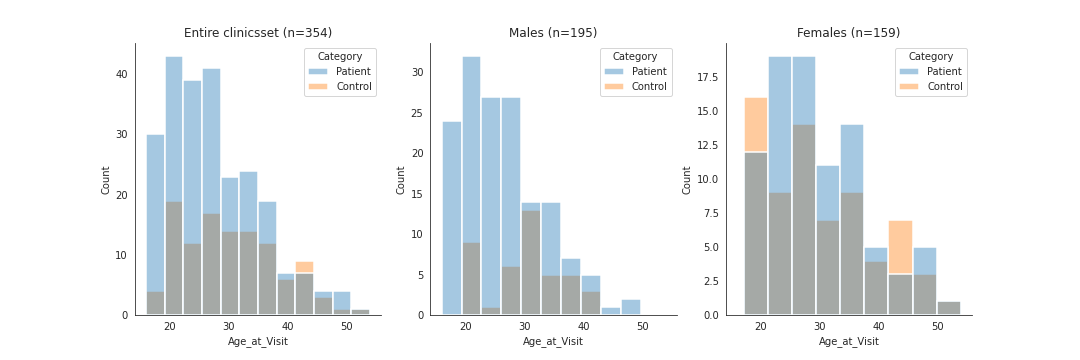

In [4]:
# Description of the clinics - Visit 1
sns.set_style("white")
fig, axes = plt.subplots(1,3, sharex=True,figsize=(15,5))
axes[0].set_title('Entire clinicsset (n='+str(clinics.shape[0])+')')
sns.histplot(data=clinics, x="Age_at_Visit",hue="Category",alpha=.4, linewidth=1.5,ax = axes[0])
axes[1].set_title('Males (n='+str(clinics[(clinics["Sex"]=="M")].shape[0])+')')
sns.histplot(data=clinics[(clinics["Sex"]=="M")], x="Age_at_Visit",hue="Category",alpha=.4, linewidth=1.5,ax = axes[1])
axes[2].set_title('Females (n='+str(clinics[(clinics["Sex"]=="F")].shape[0])+')')
sns.histplot(data=clinics[(clinics["Sex"]=="F")], x="Age_at_Visit",hue="Category",alpha=.4, linewidth=1.5,ax = axes[2])
sns.despine()



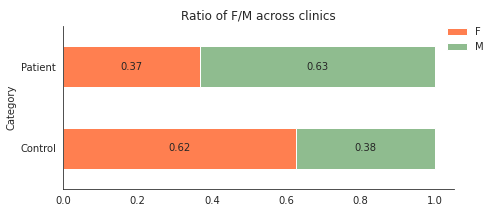

In [5]:
# Plot horizontal stacked barplots 
sdist = pd.crosstab(clinics["Category"],clinics["Sex"], normalize="index")
ndist = pd.crosstab(clinics["Category"],clinics["Sex"])

ax = sdist.plot(kind="barh", stacked=True, title="Ratio of F/M across clinics", mark_right=True, figsize=(7,3), color = ["coral", "darkseagreen"])
ax.legend(loc="upper right", frameon=False, bbox_to_anchor=(1.1, 1.05))

for c in ax.containers:
    ax.bar_label(c, fmt="%2.2f", label_type="center")

sns.despine()    

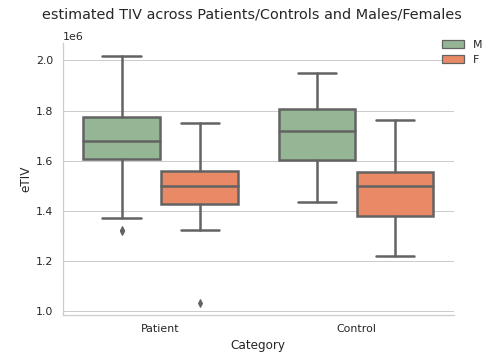

In [6]:
# Plotting estimated TIV across Patients/Controls and Males/Females
sns.set_theme(style="whitegrid")
FM_colors = ["darkseagreen","coral"]
cp = sns.set_palette(sns.color_palette(FM_colors))

fig, axes = plt.subplots(1, sharex=True,figsize=(7,5))

matplotlib.rcParams["figure.titlesize"] = "large"
fig.suptitle('estimated TIV across Patients/Controls and Males/Females')
g = sns.boxplot(data=clinics, x="Category", y="eTIV", hue="Sex", linewidth=2.5, palette = cp)
g.legend(loc="upper right", frameon=False, bbox_to_anchor=(1.1, 1.05))

sns.despine()

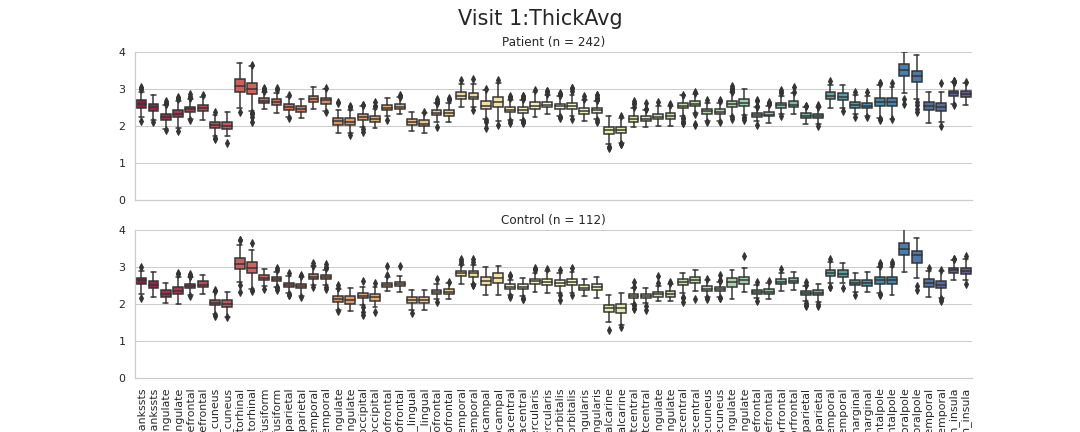

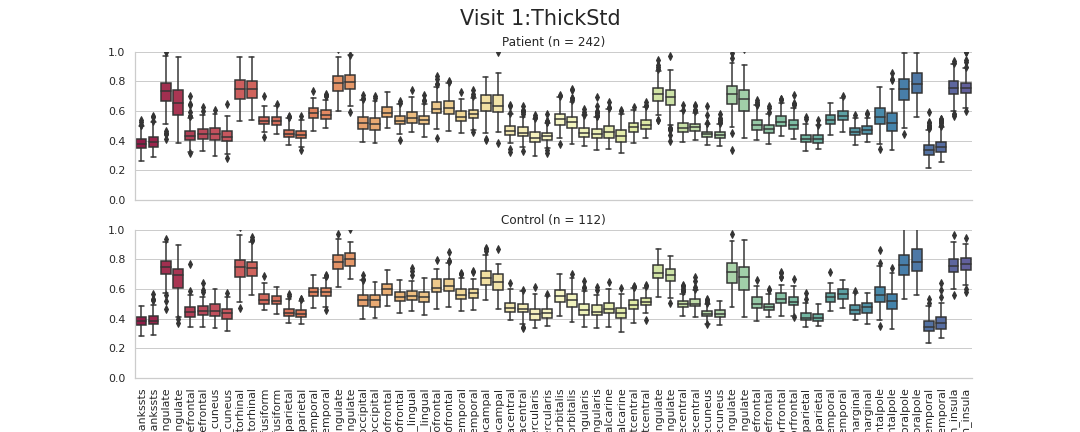

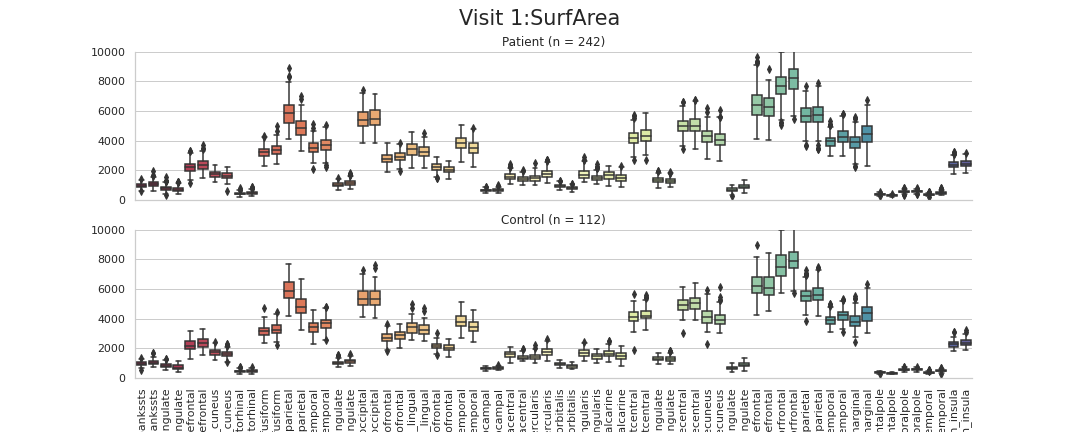

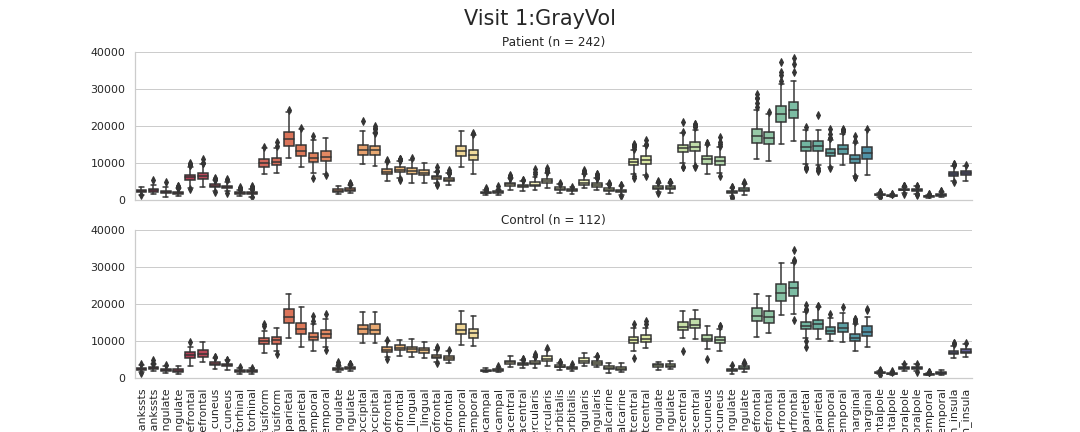

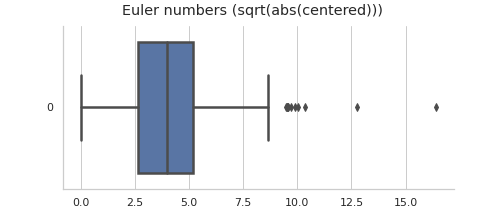

In [9]:
# which fs textfile to load?
fs_files = glob.glob(os.path.join(fsdata_dir,'aparc*.txt'))
fs_vars = ["ThickAvg", "ThickStd", "SurfArea", "GrayVol"]

for i, fs_suffix in enumerate(fs_vars):
    
    # pick the correct datafile
    fs_file = [s for s in fs_files if fs_suffix in s]
    neuro = pd.read_csv(fs_file[0], sep=";", index_col = 0)

    # create the dataset
    data = merge_and_reorder(clinics, neuro)

    # plot images
    desc_boxplots(data, fs_suffix, images_dir, save_img=False)    

    # quality control and removal of outliers using the Euler number
    if i == len(fs_vars)-1:
        save_img, img_dir, show_img = True, images_dir, True
    else:
        save_img, img_dir, show_img = False, None, False

    data_final = en_qc(data, save_img=save_img, img_dir=img_dir, show_img=show_img)

    ## Prepare data for analysis and save
    # replace males and females with numbers
    sex_nums = {"Sex": {"F":0, "M":1}}
    data_final = data.replace(sex_nums)

    # backup directory for the data
    bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup')
    os.makedirs(bdata_dir, exist_ok=True)

    data_final.to_csv(os.path.join(bdata_dir, 'all_data_'+fs_suffix+'.txt'), sep = ' ', header=True, index=True)



In [ ]:
# path
nm_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/nm_analysis')
os.makedirs(nm_dir, exist_ok=True)

# Covariates - Age and Sex
cov_norm = data_final.loc[data_final['Category']=='Control', ["Age_at_Visit","Sex"]]
cov_norm.to_csv(os.path.join(nm_dir,'cov_norm.txt'), sep=' ', header= False, index=False)

# Features - Desikan Killiany Atlas
# indices of DK
i_start = list(data.columns).index("rh_bankssts")
i_end = list(data.columns).index("lh_insula")+1

feat_norm = data_final.loc[data_final['Category']=='Control', data_final.columns[range(i_start,i_end)]]
feat_norm.to_csv(os.path.join(nm_dir,'feat_norm.txt'), sep=' ', header=False, index=False)